In [30]:
import numpy as np
import librosa
import matplotlib.pyplot as plt
from IPython.display import Audio
import IPython.display as ipd
import soundfile as sd

In [2]:
x=0.2*librosa.tone(440,sr=44000,length=1024)+0.3*librosa.tone(330,sr=44000,length=1024)
d=0.5*librosa.tone(440,sr=44000,length=1024)

In [3]:
d,sr= librosa.load('../media/nearend_mic_fileid_0.wav')
x,sr=librosa.load('../media/farend_speech_fileid_0.wav')
echo,sr=librosa.load('../media/echo_fileid_0.wav')
near_end,sr= librosa.load('../media/nearend_speech_fileid_0.wav')

In [4]:
def lms(x,d,mu,taps):
    N=len(x)
    w=np.zeros((taps,1))
    e=np.zeros_like(x)
    y=np.zeros_like(x)
    for n in range(0,N-taps):
        xd = np.flipud(x[n:n+taps])  # Slice to get view of M latest datapoints
        y[n] = np.dot(xd,w)
        e[n] = d[n] - y[n]
        F=mu*np.multiply(xd,e[n])
        F=F.reshape(F.shape[0],-1)
        w = w +F
        y[n] = np.dot(xd, w)
    
    return (y,e,w)


In [5]:
class AdaptiveFilters():
    def __init__(self,mu,taps):
        self.e=0
        self.w=np.zeros((taps,1))
        self.xd=np.zeros((taps,1))
        self.mu=mu
        self.N=taps

In [6]:

class LMS(AdaptiveFilters):
    #initialize
    def __init__(self,mu,taps):
        super().__init__(mu,taps)

    #updates the filter sample by sample and updates weights sample by sample
    def run(self,x,d):
        N=self.N
        #udpate delay line 
        self.xd[0]=x
        y = np.dot(self.w.T,self.xd)
        
        e = d - y
        
        Fw=self.mu*np.multiply(self.xd,e)
        
        Fw=Fw.reshape(Fw.shape[0],-1)
        
        self.w = self.w + Fw
    
        y = np.dot(self.w.T,self.xd)
        #shift delay line
        self.xd[1:N-1]=self.xd[0:N-2]
        self.e=e

        return (y,e,w)


In [7]:
class NLMS(AdaptiveFilters):
    #initialize
    def __init__(self,mu,taps):
        super().__init__(mu,taps)

    #updates the filter sample by sample and updates weights sample by sample
    def run(self,x,d):
        N=self.N
        #udpate delay line 
        self.xd[0]=x
        #compute filter output
        y = np.dot(self.w.T,self.xd)
        #compute input energy
        pw=np.linalg.norm(self.xd)
        #calculate error
        e = d - y
        #normalize by input energy
        e= e/(pw+0.0000001)
        #compute gradients
        Fw=self.mu*np.multiply(self.xd,e)
        
        Fw=Fw.reshape(Fw.shape[0],-1)
        #weight update
        self.w = self.w + Fw
    
        #filtered output post update
        y = np.dot(self.w.T,self.xd)
        #shift delay line
        self.xd[1:N-1]=self.xd[0:N-2]
        self.e=e

        #return current output sample, current error sample and current weights
        return (y,e,w)


In [8]:
class PNLMS(AdaptiveFilters):
    #initialize
    def __init__(self,mu,taps,rho,delta):
        super().__init__(mu,taps)
        self.delta=delta
        self.rho=rho
        self.g=np.zeros_like(self.w)

    #updates the filter sample by sample and updates weights sample by sample
    def run(self,x,d):
        N=self.N
        #udpate delay line 
        self.xd[0]=x
        #compute filter output
        y = np.dot(self.w.T,self.xd)
        #compute input energy
        pw=np.linalg.norm(self.xd)
        #calculate error
        e = d - y
        #normalize by input energy
        e= e/(pw+0.0000001)

        #computing updates
        lk= np.max(np.abs(w))
        lk= max(self.delta,lk)
        for i,wk in enumerate(w):
            self.g[i]= max(abs(wk),self.rho*lk)

        gavg=np.mean(self.g)

        #compute gradients
        Fw=self.mu* np.multiply(self.xd,e)
        Fw= np.multiply(Fw,self.g/gavg)
        Fw=Fw.reshape(Fw.shape[0],-1)

        #weight update
        self.w = self.w + Fw
    
        #filtered output post update
        y = np.dot(self.w.T,self.xd)
        #shift delay line
        self.xd[1:N-1]=self.xd[0:N-2]
        self.e=e

        #return current output sample, current error sample and current weights
        return (y,e,w)


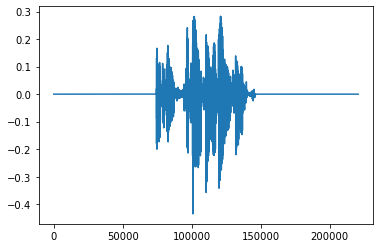

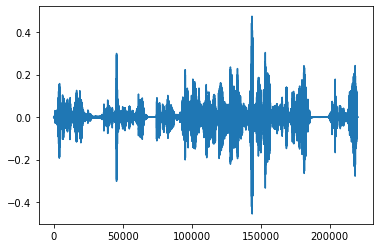

In [9]:
(y,e,w)= lms(x,d,0.1,1024)
plt.figure()
plt.plot(near_end)
plt.figure()
plt.plot(e)
#plt.plot(d)

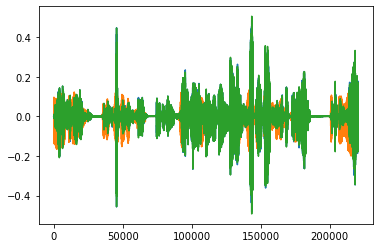

In [10]:
#test wrapper for LMS filter
lmscls= LMS(0.01,256)

y=np.zeros_like(x)
e=np.zeros_like(x)
for i in range(0,len(x)):
    (y[i],e[i],w)=lmscls.run(x[i],d[i])

plt.plot(e)
plt.plot(x)
plt.plot(d)

Text(0.5, 1.0, 'near end signal')

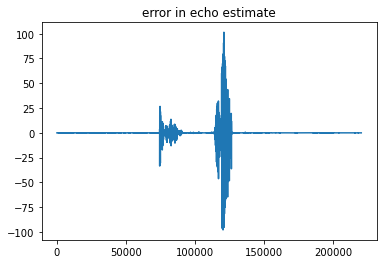

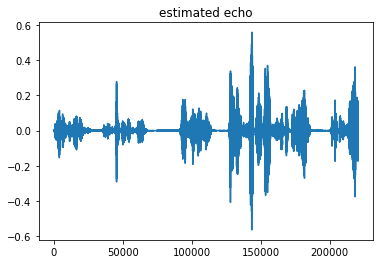

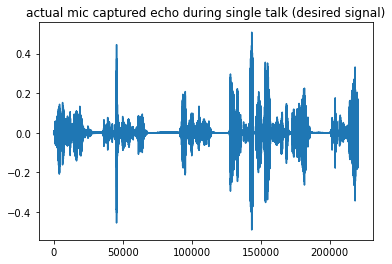

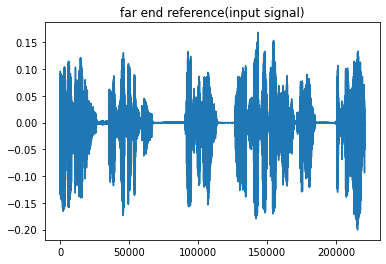

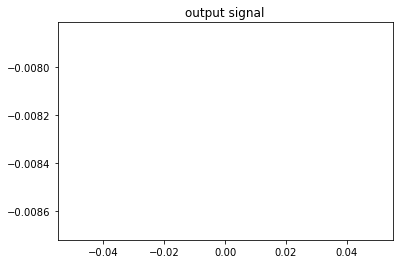

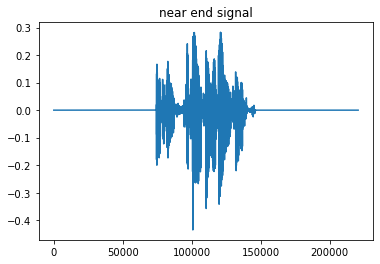

In [15]:
#test wrapper for NLMS filter on aec data for single talk case
taps=1024
lmscls= NLMS(0.1,taps)
w=np.zeros((taps,1))
y=np.zeros_like(x)
e=np.zeros_like(x)
for i in range(0,len(x)):
    (y[i],e[i],w)=lmscls.run(x[i],d[i])


out=d[i]-y[i]

plt.figure()
plt.plot(e)
plt.title("error in echo estimate")
plt.figure()
plt.plot(y)
plt.title("estimated echo")
plt.figure()
plt.plot(echo)
plt.title("actual mic captured echo during single talk (desired signal)")
plt.figure()
plt.plot(x)
plt.title("far end reference(input signal)")
plt.figure()
plt.plot(out)
plt.title("output signal")
plt.figure()
plt.plot(near_end)
plt.title("near end signal")

In [25]:
ipd.Audio(y, rate=sr)

UsageError: Line magic function `%sudo` not found.


In [12]:
#test wrapper for NLMS filter on aec data for single talk case
taps=1024
lmscls= PNLMS(0.1,taps,0.05,0.05)
w=np.zeros((taps,1))
y=np.zeros_like(x)
e=np.zeros_like(x)
for i in range(0,len(x)):
    (y[i],e[i],w)=lmscls.run(x[i],d[i])

out=d[i]-y[i]
plt.figure()
plt.plot(e)
plt.title("error in echo estimate")
plt.figure()
plt.plot(y)
plt.title("estimated echo")
plt.figure()
plt.plot(echo)
plt.title("actual mic captured echo during single talk (desired signal)")
plt.figure()
plt.plot(x)
plt.title("far end reference(input signal)")
plt.plot(out)
plt.title("output signal")

KeyboardInterrupt: 